# Importing libraries and loss function

In [1]:
import import_ipynb
from Custom_lossFunction_AK import *
import pandas
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import concatenate
import numpy
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras import datasets, layers, models, Input
import matplotlib.pyplot as plt
import json
from tensorflow.keras.callbacks import LambdaCallback

importing Jupyter notebook from Custom_lossFunction_AK.ipynb
Shape of z is (98,), while shape of J is (50,)
Shape of s and t is (500,), while shape of t_individual is (500,)


# Initializing X, Y

In [2]:
#X is a 2d array with elements (j,Z). We expect this to be a [len(J)*len(z),2]
X = [[indexJ, indexz] for indexJ in J for indexz in z]
X = np.array(X)

#Initiate target data with appropriate dimensions: len(z)*len(J)
Y=np.arange(len(z)*len(J))

# Model Settings and Initialization

Keras model information can be found at https://www.tensorflow.org/api_docs/python/tf/keras/Model

Compiler attributes: https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

In [3]:
#Initiate model and sets initial input shape
model = models.Sequential()
model.add(Input(shape=(2)))

# Neuron layers
model.add(layers.Dense(5, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1)))
model.add(layers.Dense(3, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1)))
model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=0.4))) #make sure its between 0 and 1

#Callback function
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))
#Add "callbacks = [print_weights]" as an option in model.fit if needed

#NN learning parameters
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=2000,
    decay_rate=0.9)
opt = keras.optimizers.Adagrad(learning_rate=lr_schedule)

# Compile model subject to parameters above
model.compile(optimizer =opt, loss=Custom_Loss_Function, metrics=['accuracy'])

Fit function instructions: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [69]:
# Run model fit with progress info
#history_callback = model.fit(X, Y, epochs=5000, batch_size=np.kron(J,z).shape[0], verbose=1 , shuffle = False, callbacks = [print_weights])
#loss_history = history_callback.history["loss"]

In [4]:
# Run model fit without showing progress
history_callback = model.fit(X, Y, epochs=5000, batch_size=np.kron(J,z).shape[0], verbose=0 , shuffle = False)
loss_history = history_callback.history["loss"]

# Tests

## Plotting & Loss analysis

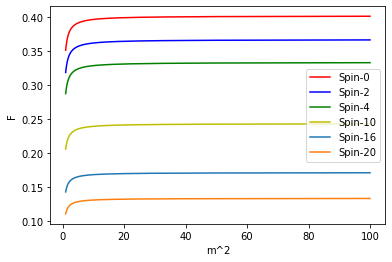

In [5]:
# Generate (z,X) to be plotted. Recall that z=1/m^2 and therefore plotting the inverse of z 
# is physically easier to interpret
plotZvar = np.arange(0.01,0.99,1/200)
X11 = [[0, indexZ] for indexZ in plotZvar]
X22 = [[2, indexZ] for indexZ in plotZvar]
X33 = [[4, indexZ] for indexZ in plotZvar]
X44 = [[10, indexZ] for indexZ in plotZvar]
X55 = [[16, indexZ] for indexZ in plotZvar]
X66 = [[20, indexZ] for indexZ in plotZvar]
plotm = 1/plotZvar

# Apply fit result to X's above
plt.plot(plotm, model.predict(X11),color = 'r' )
plt.plot(plotm, model.predict(X22), color = 'b')
plt.plot(plotm, model.predict(X33),color = 'g')
plt.plot(plotm, model.predict(X44),color = 'y')
plt.plot(plotm, model.predict(X55))
plt.plot(plotm, model.predict(X66))
plt.xlabel("m^2")
plt.ylabel("F")
plt.legend(['Spin-0','Spin-2','Spin-4','Spin-10','Spin-16','Spin-20'])
#plt.savefig('Weights/0.1/plt.png')
plt.show()

In [6]:
#Create array of [sum1, sum2, sum3]
print(["{:2e}".format(crossing_Symmetry_Square(M, model.predict(X)).numpy()), "{:2e}".format(einstein_Gravity_Min(K_A, model.predict(X),1).numpy()), "{:2e}".format(tf.tensordot(K_B, model.predict(X), axes=1).numpy()[0])])

['1.968330e+25', '1.847003e+06', '1.027817e+06']


In [ ]:
['1.150905e+11', '4.307767e+07', '1.214264e+08'

## Saving

Save function: https://www.tensorflow.org/api_docs/python/tf/keras/Model#save <br>
Model format: Either 'tf' or 'h5', indicating whether to save the model to Tensorflow SavedModel or HDF5. Defaults to 'tf' in TF 2.X, and 'h5' in TF 1.X. <br>
Save weights' function: https://www.tensorflow.org/api_docs/python/tf/keras/Model#save_weights

In [ ]:
# Saving test
print(model.predict(X).shape)
#a_file = open("Weights/0.1/F.txt", "w")
#for row in model.predict(X):
#np.savetxt(a_file, model.predict(X))
#a_file.close()

model.save("test/random/mymodel", overwrite=True, include_optimizer=True, save_traces=True)
model.save_weights("test/random/mymodel_weights", overwrite=True)

# Systematic Analysis

## Initializer stddev

In [ ]:
stddevList=np.array([0.5,0.4,0.3,0.2,0.1,0.01])
modelFilenameList=["stddev/test1/model_std05","stddev/test1/model_std04","stddev/test1/model_std03","stddev/test1/model_std02","stddev/test1/model_std01","stddev/test1/model_std001"]
weightsFilenameList=["stddev/test1/weights_std05","stddev/test1/weights_std04","stddev/test1/weights_std03","stddev/test1/weights_std02","stddev/test1/weights_std01","stddev/test1/weights_std001"]

for ind in range(len(stddevList)):
    # (Re-)Initiate model
    model = models.Sequential()
    model.add(Input(shape=(2)))
    
    # Neuron layers
    model.add(layers.Dense(5, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=stddevList[[ind]])))
    model.add(layers.Dense(3, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1)))
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=0.4))) #make sure its between 0 and 1
    
    #NN learning parameters
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=2000,
        decay_rate=0.9)
    opt = keras.optimizers.Adagrad(learning_rate=lr_schedule)

    # Compile model subject to parameters above
    model.compile(optimizer =opt, loss=Custom_Loss_Function, metrics=['accuracy'])
    
    # Run model fit
    history_callback = model.fit(X, Y, epochs=5000, batch_size=np.kron(J,z).shape[0], verbose=0 , shuffle = False)

    # Save model and data
    model.save(modelFilenameList[ind], overwrite=True, include_optimizer=True, save_traces=True)
    model.save_weights(weightsFilenameList[ind], overwrite=True)

In [ ]:
modelFilenameList[0]